### Imports

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split


# import warnings
# warnings.filterwarnings('ignore')


### Read and clean data

In [32]:
df = pd.read_csv("data/meteorite-landings.csv")
X = df.columns
y = df['recclass']

df = df[df['year'] < 2016]
df = df[(df['reclat'] != 0) & (df['reclong'] != 0)]
df = df[(df['reclat'] > -90) & (df['reclat'] < 90)]
df = df[(df['reclong'] > -180) & (df['reclong'] < 180)]
df = df.dropna()

### High-level overview of data

In [33]:
results = dict()

for feature in ["mass (g)", "year", "reclat", "reclong"]:
    mean = df[feature].mean()
    std = df[feature].std()
    results[feature] = {"mean": mean, "std": std}

for feature in ["recclass", "fall"]:
    results[feature] = df[feature].value_counts()

results

{'mass (g)': {'mean': 18673.585234347895, 'std': 689269.8866294333},
 'year': {'mean': 1987.0870840561427, 'std': 26.791227836776162},
 'reclat': {'mean': -47.6020087506387, 'std': 46.71417100985546},
 'reclong': {'mean': 73.45260691108659, 'std': 83.41908257017013},
 'recclass': L6                 6523
 H5                 5549
 H4                 3320
 H6                 3051
 L5                 2723
                    ... 
 H3.5-4                1
 L4-an                 1
 L-melt breccia        1
 Mesosiderite-B2       1
 L5-7                  1
 Name: recclass, Length: 392, dtype: int64,
 'fall': Found    30642
 Fell      1063
 Name: fall, dtype: int64}

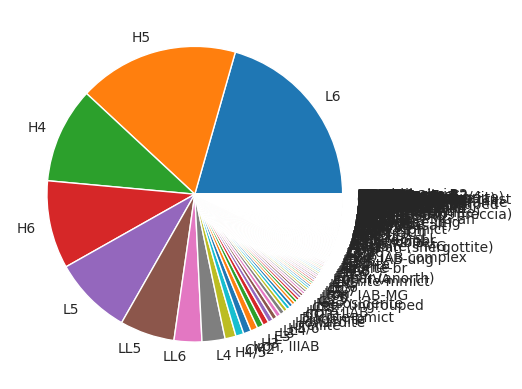

In [34]:
# Make a pie chart of the recclass
plt.figure()
plt.pie(results['recclass'], labels=results['recclass'].index)
plt.show()

<AxesSubplot:title={'center':'Number of Meteorites that Fell Each Year'}, xlabel='year'>

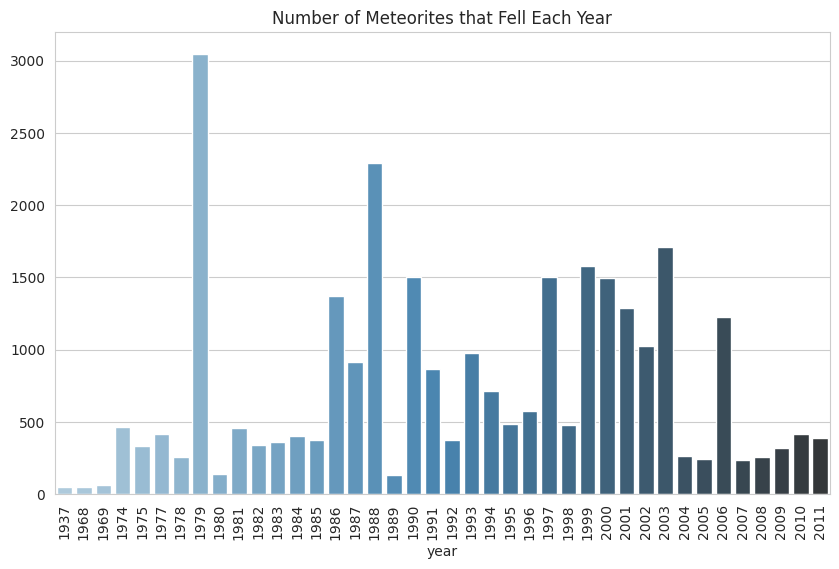

In [35]:
# Calculate how many meteorites fell in each year
year_counts = df.groupby("year").count()["name"]

# Drop years with less than 10 meteorites
year_counts = year_counts[year_counts > 50]

# remove the decmial point from the year
year_counts.index = year_counts.index.astype(int)

# using sns Plot the number of meteorites that fell each year ordered by count
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
plt.title("Number of Meteorites that Fell Each Year")
plt.xticks(rotation=90)
sns.barplot(x=year_counts.index, y=year_counts.values, palette="Blues_d")

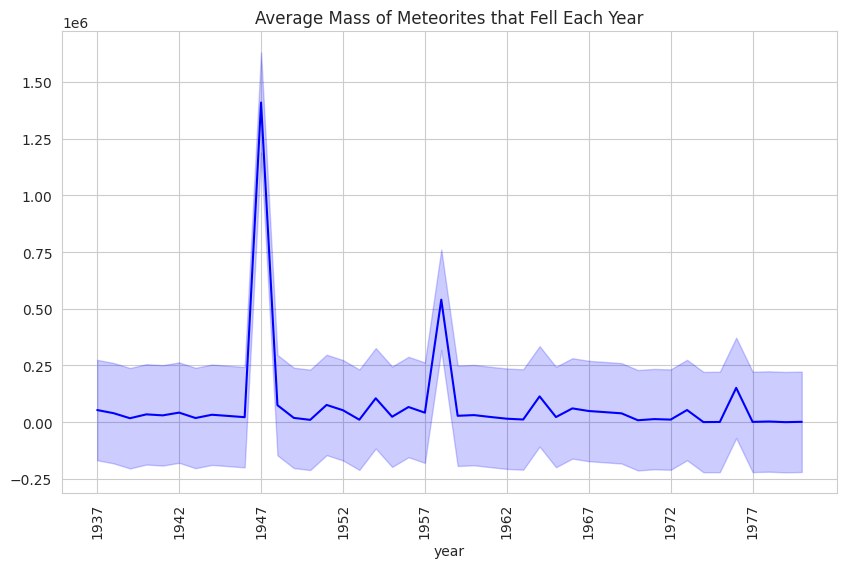

In [36]:
# Plot the average mass of the meteorites ordered by year
# only include years between 1937 and 1980
mass_by_year = df[(df["year"] >= 1937) & (df["year"] <= 1980)].groupby("year").mean()["mass (g)"]


# Plot the mean mass of the meteorites that fell each year along with the standard deviation
plt.figure(figsize=(10, 6))
plt.title("Average Mass of Meteorites that Fell Each Year")
plt.xticks(np.arange(1937, 1980, 5),rotation=90)
sns.lineplot(x=mass_by_year.index, y=mass_by_year.values, color="blue")
plt.fill_between(
    x=mass_by_year.index,
    y1=mass_by_year.values - mass_by_year.std(),
    y2=mass_by_year.values + mass_by_year.std(),
    alpha=0.2,
    color="blue",
)

Text(0.5, 1.0, 'Latitude vs Longitude of Meteorite Landings')

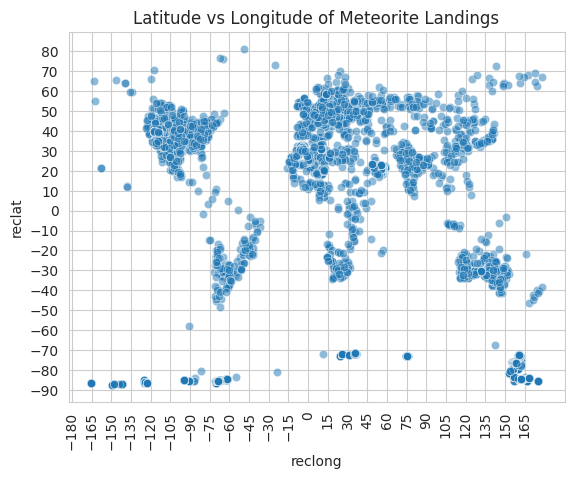

In [37]:
# Print a plot of reclat vs reclong
sns.scatterplot(x=df["reclong"], y=df["reclat"], alpha=0.5)
plt.xticks(np.arange(-180, 180, 15), rotation=90)
plt.yticks(np.arange(-90, 90, 10))
plt.title("Latitude vs Longitude of Meteorite Landings")


In [38]:
# plt.title("Number of Meteorites that Fell in Each Location")
# plt.xlabel("Longitude")
# plt.ylabel("Latitude")
# plt.xticks(np.arange(-180, 180, 30))
# plt.yticks(np.arange(-90, 90, 15))
# sns.heatmap(
#     df.groupby(["reclat", "reclong"]).count()["mass (g)"].unstack(),
#     cmap="Blues",
#     cbar_kws={"label": "Number of Meteorites"},
# )

### MAP STUF

In [39]:
# show a map of the world with the meteorite landings
import folium
from folium.plugins import HeatMap

# Create a map of the world
m = folium.Map(location=[0, 0], max_zoom = 16, zoom_start=12)

heat_df = df[["reclat", "reclong"]].dropna()
heat_df = heat_df.dropna(axis=0, subset=["reclat", "reclong"])
heat_data = [[row["reclat"], row["reclong"]] for _, row in heat_df.iterrows()]
HeatMap(heat_data).add_to(m)

# Show the map
# m

### MACHINE LEARNING

In [40]:
# down select to recclass and mass 
tdf = df[["recclass", "mass (g)", "reclat", "reclong", "year", "fall"]].dropna()
tdf = tdf[tdf["year"] > 1975]
tdf = tdf[tdf["year"] < 2015]
tdf = tdf[tdf["mass (g)"] < 1000]

# drop recclass columns
drop_c = 0
drop_m = 0
drop_f = 1
if drop_m:
    tdf = tdf.drop(columns=["mass (g)"])
if drop_f:
    tdf = tdf.drop(columns=["fall"])
else:
    tdf["fall"] = tdf["fall"].apply(lambda x: 1 if x == "Fell" else 0)
if drop_c:
    tdf = tdf.drop(columns=["recclass"])
else:
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    tdf["recclass"] = le.fit_transform(tdf["recclass"])

ty = tdf["year"]
tdf


only_us = 0
if only_us:
    # Limit the data to latitudes and longitudes within the US
    tdf = tdf[(tdf["reclat"] > 25) & (tdf["reclat"] < 50)]
    tdf = tdf[(tdf["reclong"] > -125) & (tdf["reclong"] < -65)]

    # split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        tdf[["reclat", "reclong"]], tdf["year"], test_size=0.42, random_state=42
    )
    X_train
else:
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        tdf, ty, test_size=0.42, random_state=42
    )
    X_train

<AxesSubplot:>

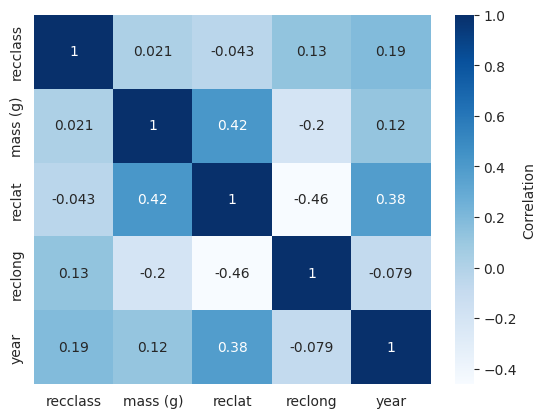

In [41]:

plt.figure()
sns.heatmap(
    tdf.corr(),
    annot=True,
    cmap="Blues",
    cbar_kws={"label": "Correlation"},
)


In [42]:
# Use KNN Classifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

neighbors = np.arange(1, 250, 1)

# Create a KNN classifier
results = dict()
for n in neighbors:
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    results[n] = accuracy_score(y_test, y_pred)


<AxesSubplot:title={'center':'Accuracy of KNN Classifier'}, xlabel='Number of Neighbors', ylabel='Accuracy'>

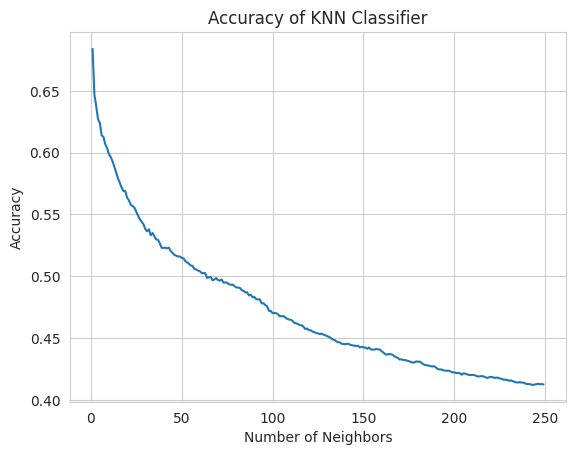

In [43]:

# Plot the accuracy of the KNN classifier
plt.figure()
plt.title("Accuracy of KNN Classifier")
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy")
sns.lineplot(x=list(results.keys()), y=list(results.values()))

In [44]:
# Use KNN to predict the year and mass of the meteorite
from sklearn.neighbors import KNeighborsRegressor

results = dict()
for w in ["uniform", "distance"]:
    for n in neighbors:
        knn = KNeighborsRegressor(n_neighbors=n, weights=w, )
        knn.fit(X_train, y_train)
        results[(w, n)] = knn.score(X_test, y_test)
results

{('uniform', 1): 0.9126937718054989,
 ('uniform', 2): 0.9229460634017552,
 ('uniform', 3): 0.922101235098804,
 ('uniform', 4): 0.9213392282180076,
 ('uniform', 5): 0.9184148683114456,
 ('uniform', 6): 0.9152284981542274,
 ('uniform', 7): 0.9115308618650579,
 ('uniform', 8): 0.9085804625109075,
 ('uniform', 9): 0.9054323602553258,
 ('uniform', 10): 0.9026977807086526,
 ('uniform', 11): 0.9001207084995828,
 ('uniform', 12): 0.8966198215809192,
 ('uniform', 13): 0.8936200659605718,
 ('uniform', 14): 0.8903177444109232,
 ('uniform', 15): 0.8873567091529381,
 ('uniform', 16): 0.8846723763775421,
 ('uniform', 17): 0.8817031526199354,
 ('uniform', 18): 0.8791149008099466,
 ('uniform', 19): 0.8766440529944511,
 ('uniform', 20): 0.8742757665292076,
 ('uniform', 21): 0.8723399841067379,
 ('uniform', 22): 0.8702873434778551,
 ('uniform', 23): 0.8682163864246438,
 ('uniform', 24): 0.866145912439516,
 ('uniform', 25): 0.8639548552819059,
 ('uniform', 26): 0.8617989508107613,
 ('uniform', 27): 0.860

('distance', 4) 0.9301104911308228


<AxesSubplot:title={'center':'Accuracy of KNN Regressor'}, xlabel='Number of Neighbors', ylabel='Accuracy'>

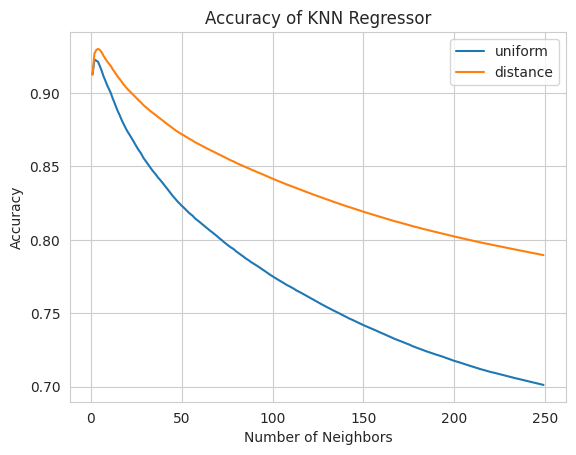

In [45]:
#print the highest accuracy
print(max(results, key=results.get), results[max(results, key=results.get)])


# for each ["uniform" or "distance"] and each number of neighbors
# plot the accuracy of the KNN regressor
plt.figure()
plt.title("Accuracy of KNN Regressor")
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy")
sns.lineplot(
    x=[n for _, n in results.keys()],
    y=list(results.values()),
    hue=[w for w, _ in results.keys()],
)
